In [4]:
#!pip install fedot

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [6]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [7]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()

In [8]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [9]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 5000
end = 6000
series = 'traffic'

if series == 'traffic':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


2022-11-24 17:34:06,741 - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


DEBUG:h5py._conv:Creating converter from 7 to 5


2022-11-24 17:34:07,173 - Creating converter from 7 to 5


DEBUG:h5py._conv:Creating converter from 5 to 7


2022-11-24 17:34:07,180 - Creating converter from 5 to 7


DEBUG:h5py._conv:Creating converter from 7 to 5


2022-11-24 17:34:07,188 - Creating converter from 7 to 5


DEBUG:h5py._conv:Creating converter from 5 to 7


2022-11-24 17:34:07,196 - Creating converter from 5 to 7


DEBUG:root:Initializing MLIR with module: _site_initialize_0


2022-11-24 17:34:07,550 - Initializing MLIR with module: _site_initialize_0


DEBUG:root:Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._site_initialize_0' from '/usr/local/lib/python3.7/dist-packages/jaxlib/mlir/_mlir_libs/_site_initialize_0.so'>


2022-11-24 17:34:07,556 - Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._site_initialize_0' from '/usr/local/lib/python3.7/dist-packages/jaxlib/mlir/_mlir_libs/_site_initialize_0.so'>


DEBUG:jax._src.path:etils.epath found. Using etils.epath for file I/O.


2022-11-24 17:34:07,683 - etils.epath found. Using etils.epath for file I/O.


INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


2022-11-24 17:34:08,903 - 'pattern' package not found; tag filters are not available for English


In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 17:34:14,231 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 17:34:14,240 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:34:14,247 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 17:34:14,253 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:34:14,256 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 17:34:14,259 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 17:34:14,382 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:34:14,538 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:34:14,545 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:34:14,551 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:34:14,555 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 17:34:14,558 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 17:34:14,565 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 17:34:14,572 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2022-11-24 17:34:14,577 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


2022-11-24 17:34:14,596 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 17:34:14,624 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 17:34:14,629 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 17:34:14,643 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 17:34:22,510 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.938198928380153, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 17:34:22,515 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.938198928380153, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 17:34:22,519 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.1 min


2022-11-24 17:34:22,523 - EvoGraphOptimizer - spent time: 0.1 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 17:34:24,182 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 17:34:44,020 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.7529516631888553, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 17:34:44,025 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.7529516631888553, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 17:34:44,029 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2022-11-24 17:34:44,032 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 17:34:44,036 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 17:34:44,828 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 17:35:05,713 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.7529516631888553, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 17:35:05,719 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.7529516631888553, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 17:35:05,722 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2022-11-24 17:35:05,726 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-24 17:35:05,730 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 17:35:07,033 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 17:35:26,602 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.4958583340017784, <ComplexityMetricsEnum.node_num: 'node_number'>: 1.0}]


2022-11-24 17:35:26,613 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 3.4958583340017784, <ComplexityMetricsEnum.node_num: 'node_number'>: 1.0}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 17:35:26,621 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2022-11-24 17:35:26,624 - EvoGraphOptimizer - spent time: 1.2 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-24 17:35:26,628 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [01:11<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.2 min


2022-11-24 17:35:26,633 - OptimisationTimer - Composition time: 1.2 min


INFO:root:GPComposer - GP composition finished


2022-11-24 17:35:26,641 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 17:35:26,967 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 17:35:27,807 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 8, 'length': 10, 'nodes': [ridge, ridge, glm, ridge, ridge, glm, ridge, sparse_lagged, linear, decompose]}


2022-11-24 17:35:27,817 - FEDOT logger - Final pipeline: {'depth': 8, 'length': 10, 'nodes': [ridge, ridge, glm, ridge, ridge, glm, ridge, sparse_lagged, linear, decompose]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:35:27,824 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:35:27,830 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: linear


2022-11-24 17:35:27,834 - SecondaryNode - Obtain prediction in secondary node with operation: linear


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: linear


2022-11-24 17:35:27,837 - SecondaryNode - Fit all parent nodes in secondary node with operation: linear


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: decompose


2022-11-24 17:35:27,841 - SecondaryNode - Obtain prediction in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


2022-11-24 17:35:27,847 - SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:35:27,852 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:35:27,857 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:35:27,863 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:35:27,868 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:35:27,873 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:35:27,885 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 17:35:27,889 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 17:35:27,894 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: sparse_lagged


2022-11-24 17:35:27,899 - PrimaryNode - Predict in primary node by operation: sparse_lagged


2022-11-24 17:35:28,076 - OperationTypesRepository - Operation sparse_lagged not found in the repository


2022-11-24 17:35:28,082 - OperationTypesRepository - Operation decompose not found in the repository


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.


2022-11-24 17:35:28,248 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,256 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


2022-11-24 17:35:28,261 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,264 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,267 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


2022-11-24 17:35:28,270 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,272 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,276 - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,279 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,282 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,284 - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,287 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,290 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


2022-11-24 17:35:28,293 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,296 - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,300 - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


2022-11-24 17:35:28,303 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,306 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,309 - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,313 - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


2022-11-24 17:35:28,316 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,319 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,322 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,326 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,329 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


2022-11-24 17:35:28,332 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,335 - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,338 - findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,342 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,345 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,348 - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,351 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,354 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,357 - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,360 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:28,363 - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,366 - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,369 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,372 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,375 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,378 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,381 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,384 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,387 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


2022-11-24 17:35:28,390 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,393 - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,396 - findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,399 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:28,402 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:28,405 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


2022-11-24 17:35:28,408 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:28,411 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


2022-11-24 17:35:28,414 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,417 - findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:28,420 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


2022-11-24 17:35:28,422 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


2022-11-24 17:35:28,426 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


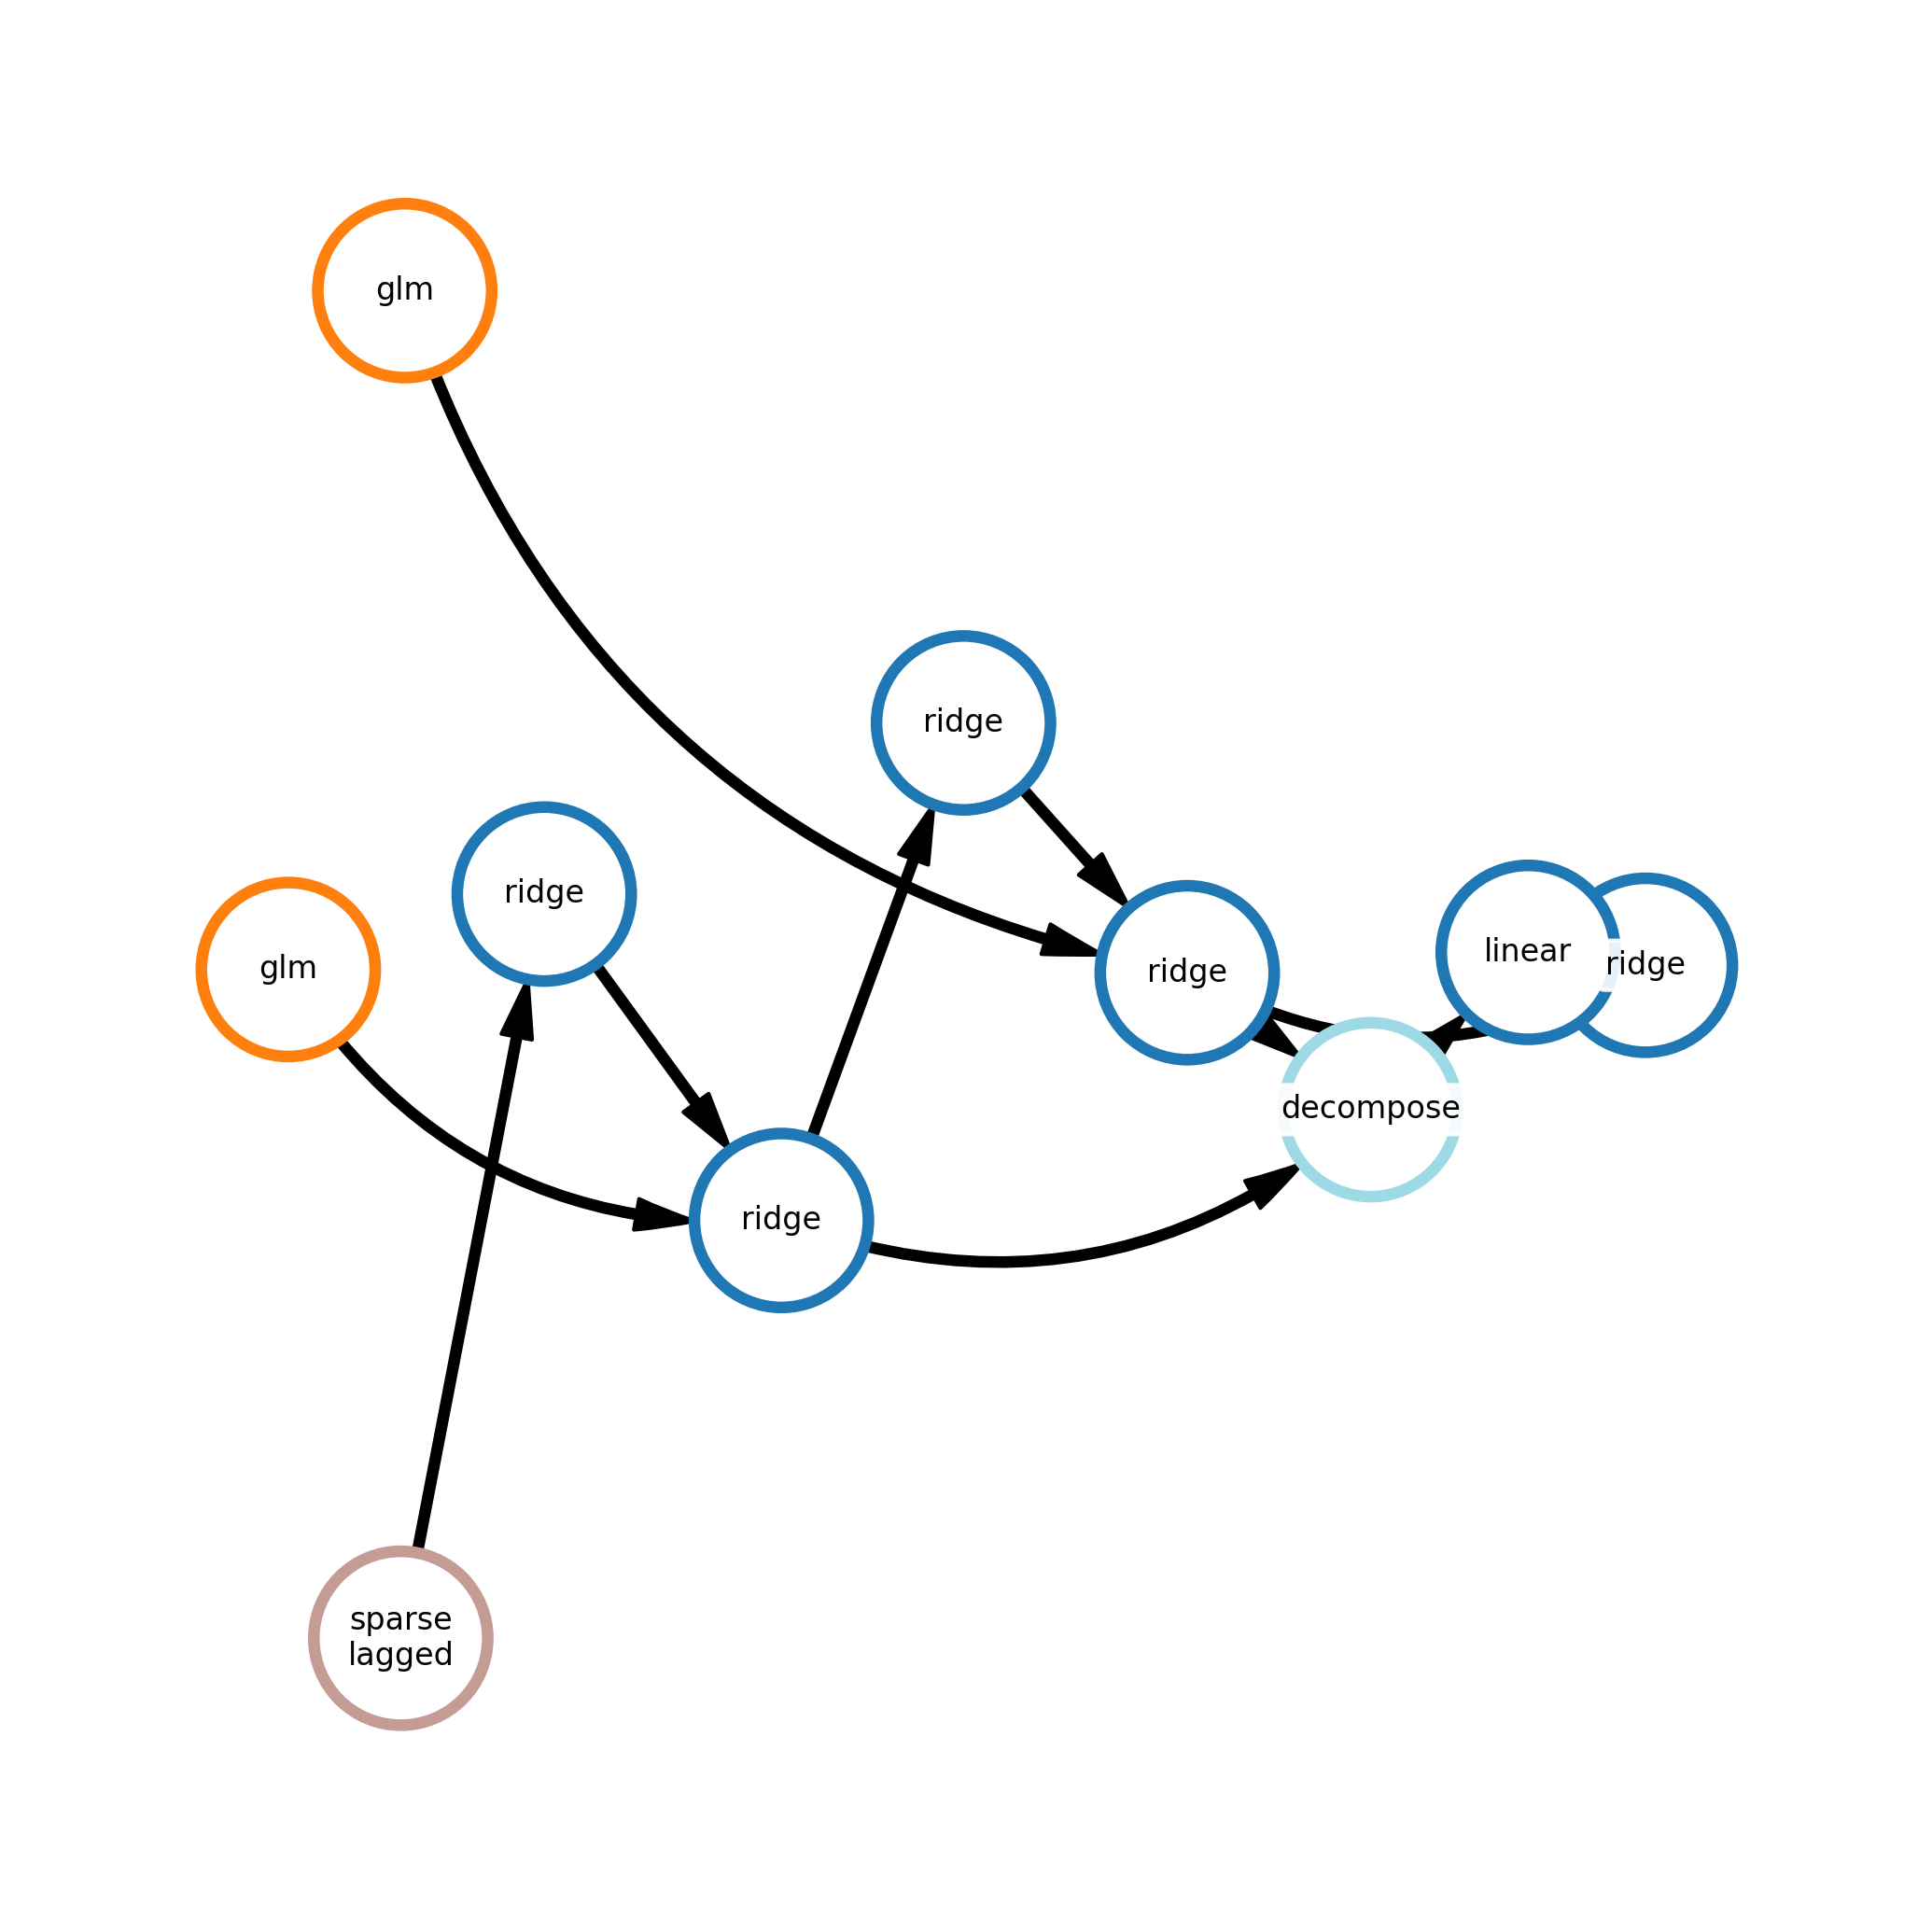

In [10]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.


2022-11-24 17:35:47,770 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,777 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


2022-11-24 17:35:47,781 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,785 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,788 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


2022-11-24 17:35:47,792 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,795 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,798 - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,801 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,804 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,808 - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,810 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,814 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


2022-11-24 17:35:47,816 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,819 - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,822 - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


2022-11-24 17:35:47,825 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,828 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,830 - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,833 - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


2022-11-24 17:35:47,836 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,839 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,841 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,844 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,847 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


2022-11-24 17:35:47,850 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,852 - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,856 - findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,859 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,862 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,865 - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,868 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,879 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,882 - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,887 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


2022-11-24 17:35:47,891 - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,894 - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,897 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,900 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,903 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,905 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,908 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,911 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,914 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


2022-11-24 17:35:47,917 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,920 - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,923 - findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,926 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 17:35:47,929 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 17:35:47,932 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


2022-11-24 17:35:47,935 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 17:35:47,937 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


2022-11-24 17:35:47,940 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,943 - findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 17:35:47,946 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


2022-11-24 17:35:47,948 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


2022-11-24 17:35:47,951 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


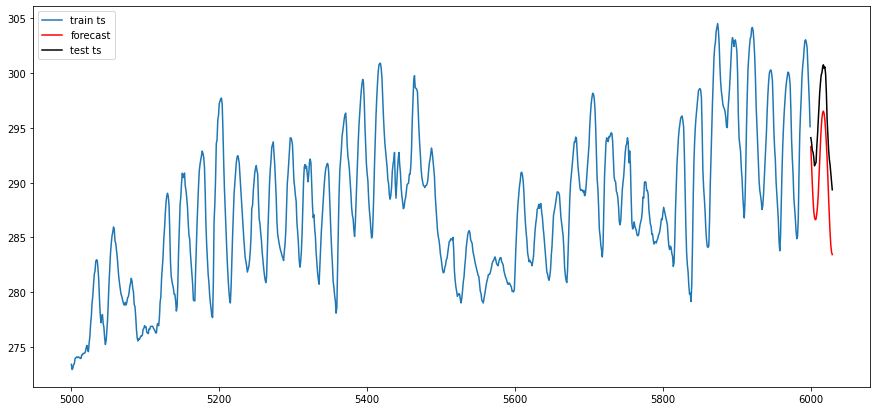

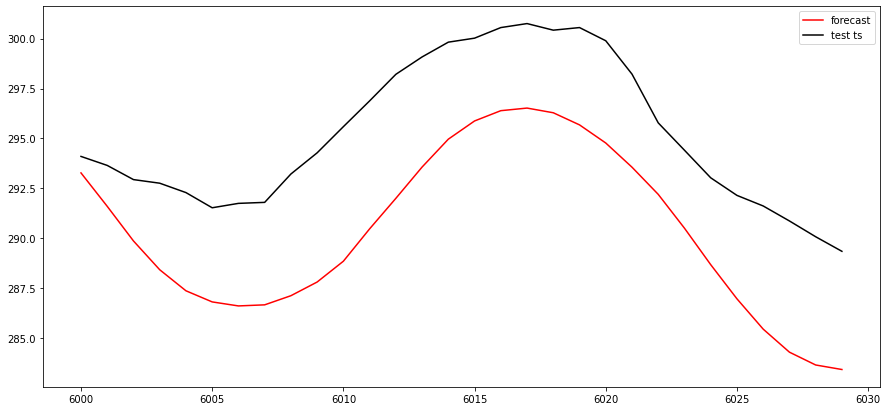

In [11]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [12]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [13]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 17:36:11,836 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 17:36:11,844 - DataSourceSplitter - Hold out validation is applied.


In [14]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [15]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [16]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [17]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 17:36:20,080 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006484 seconds


2022-11-24 17:36:20,334 - build_posterior_wrapper took 0.006484 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:36:20,348 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.16trial/s, best loss: 3.6550567311325515]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003919 seconds


2022-11-24 17:36:21,196 - build_posterior_wrapper took 0.003919 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.655057


2022-11-24 17:36:21,202 - TPE using 1/1 trials with best loss 3.655057
 20%|██        | 2/10 [00:01<00:06,  1.32trial/s, best loss: 2.795436005874839] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007362 seconds


2022-11-24 17:36:21,883 - build_posterior_wrapper took 0.007362 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.795436


2022-11-24 17:36:21,889 - TPE using 2/2 trials with best loss 2.795436
 30%|███       | 3/10 [00:03<00:09,  1.40s/trial, best loss: 2.795436005874839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004074 seconds


2022-11-24 17:36:24,052 - build_posterior_wrapper took 0.004074 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.795436


2022-11-24 17:36:24,058 - TPE using 3/3 trials with best loss 2.795436
 40%|████      | 4/10 [00:09<00:18,  3.06s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007938 seconds


2022-11-24 17:36:29,646 - build_posterior_wrapper took 0.007938 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.780953


2022-11-24 17:36:29,653 - TPE using 4/4 trials with best loss 1.780953
 50%|█████     | 5/10 [00:13<00:16,  3.32s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008590 seconds


2022-11-24 17:36:33,421 - build_posterior_wrapper took 0.008590 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.780953


2022-11-24 17:36:33,431 - TPE using 5/5 trials with best loss 1.780953
 60%|██████    | 6/10 [00:19<00:17,  4.29s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011142 seconds


2022-11-24 17:36:39,594 - build_posterior_wrapper took 0.011142 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.780953


2022-11-24 17:36:39,603 - TPE using 6/6 trials with best loss 1.780953
 70%|███████   | 7/10 [00:20<00:09,  3.21s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008123 seconds


2022-11-24 17:36:40,598 - build_posterior_wrapper took 0.008123 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.780953


2022-11-24 17:36:40,605 - TPE using 7/7 trials with best loss 1.780953
 80%|████████  | 8/10 [00:22<00:06,  3.03s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007711 seconds


2022-11-24 17:36:43,244 - build_posterior_wrapper took 0.007711 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.780953


2022-11-24 17:36:43,250 - TPE using 8/8 trials with best loss 1.780953
 90%|█████████ | 9/10 [00:23<00:02,  2.38s/trial, best loss: 1.7809532759517324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007751 seconds


2022-11-24 17:36:44,196 - build_posterior_wrapper took 0.007751 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.780953


2022-11-24 17:36:44,204 - TPE using 9/9 trials with best loss 1.780953
100%|██████████| 10/10 [00:26<00:00,  2.65s/trial, best loss: 1.7809532759517324]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:36:52,524 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.781 equal or better than initial (+ 5% deviation) 2.570


2022-11-24 17:36:52,528 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.781 equal or better than initial (+ 5% deviation) 2.570


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:36:56,269 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011060 seconds


2022-11-24 17:37:02,010 - build_posterior_wrapper took 0.011060 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:37:02,021 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:20,  2.30s/trial, best loss: 1.0120361634669417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004090 seconds


2022-11-24 17:37:04,306 - build_posterior_wrapper took 0.004090 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.012036


2022-11-24 17:37:04,315 - TPE using 1/1 trials with best loss 1.012036
 20%|██        | 2/10 [00:02<00:09,  1.20s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007293 seconds


2022-11-24 17:37:04,741 - build_posterior_wrapper took 0.007293 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.297633


2022-11-24 17:37:04,747 - TPE using 2/2 trials with best loss 0.297633
 30%|███       | 3/10 [00:05<00:14,  2.09s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007308 seconds


2022-11-24 17:37:07,898 - build_posterior_wrapper took 0.007308 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.297633


2022-11-24 17:37:07,903 - TPE using 3/3 trials with best loss 0.297633
 40%|████      | 4/10 [00:09<00:15,  2.66s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008032 seconds


2022-11-24 17:37:11,435 - build_posterior_wrapper took 0.008032 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.297633


2022-11-24 17:37:11,440 - TPE using 4/4 trials with best loss 0.297633
 50%|█████     | 5/10 [00:15<00:20,  4.02s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004158 seconds


2022-11-24 17:37:17,862 - build_posterior_wrapper took 0.004158 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.297633


2022-11-24 17:37:17,872 - TPE using 5/5 trials with best loss 0.297633
 60%|██████    | 6/10 [00:20<00:16,  4.16s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006673 seconds


2022-11-24 17:37:22,283 - build_posterior_wrapper took 0.006673 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.297633


2022-11-24 17:37:22,288 - TPE using 6/6 trials with best loss 0.297633
 70%|███████   | 7/10 [00:21<00:09,  3.06s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006723 seconds


2022-11-24 17:37:23,090 - build_posterior_wrapper took 0.006723 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.297633


2022-11-24 17:37:23,095 - TPE using 7/7 trials with best loss 0.297633
 80%|████████  | 8/10 [00:23<00:05,  2.72s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004524 seconds


2022-11-24 17:37:25,082 - build_posterior_wrapper took 0.004524 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.297633


2022-11-24 17:37:25,088 - TPE using 8/8 trials with best loss 0.297633
 90%|█████████ | 9/10 [00:25<00:02,  2.52s/trial, best loss: 0.2976328885887273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008992 seconds


2022-11-24 17:37:27,156 - build_posterior_wrapper took 0.008992 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.297633


2022-11-24 17:37:27,165 - TPE using 9/9 trials with best loss 0.297633
100%|██████████| 10/10 [00:30<00:00,  3.01s/trial, best loss: 0.2976328885887273]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:37:32,523 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.298 equal or better than initial (+ 5% deviation) 0.675


2022-11-24 17:37:32,532 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.298 equal or better than initial (+ 5% deviation) 0.675


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 17:37:32,847 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007768 seconds


2022-11-24 17:37:33,119 - build_posterior_wrapper took 0.007768 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:37:33,124 - TPE using 0 trials
 10%|█         | 1/10 [00:05<00:52,  5.86s/trial, best loss: 4.0175355197522515]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007871 seconds


2022-11-24 17:37:38,981 - build_posterior_wrapper took 0.007871 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.017536


2022-11-24 17:37:38,985 - TPE using 1/1 trials with best loss 4.017536
 20%|██        | 2/10 [00:06<00:22,  2.81s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004294 seconds


2022-11-24 17:37:39,655 - build_posterior_wrapper took 0.004294 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.810570


2022-11-24 17:37:39,666 - TPE using 2/2 trials with best loss 2.810570
 30%|███       | 3/10 [00:12<00:29,  4.27s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006771 seconds


2022-11-24 17:37:45,671 - build_posterior_wrapper took 0.006771 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.810570


2022-11-24 17:37:45,678 - TPE using 3/3 trials with best loss 2.810570
 40%|████      | 4/10 [00:16<00:25,  4.30s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008512 seconds


2022-11-24 17:37:50,010 - build_posterior_wrapper took 0.008512 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.810570


2022-11-24 17:37:50,018 - TPE using 4/4 trials with best loss 2.810570
 50%|█████     | 5/10 [00:21<00:22,  4.44s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004389 seconds


2022-11-24 17:37:54,694 - build_posterior_wrapper took 0.004389 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.810570


2022-11-24 17:37:54,704 - TPE using 5/5 trials with best loss 2.810570
 60%|██████    | 6/10 [00:25<00:16,  4.11s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008607 seconds


2022-11-24 17:37:58,178 - build_posterior_wrapper took 0.008607 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.810570


2022-11-24 17:37:58,185 - TPE using 6/6 trials with best loss 2.810570
 70%|███████   | 7/10 [00:27<00:10,  3.54s/trial, best loss: 2.8105704316308304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006818 seconds


2022-11-24 17:38:00,521 - build_posterior_wrapper took 0.006818 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.810570


2022-11-24 17:38:00,527 - TPE using 7/7 trials with best loss 2.810570
 80%|████████  | 8/10 [00:28<00:05,  2.60s/trial, best loss: 2.531703407338425] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007136 seconds


2022-11-24 17:38:01,128 - build_posterior_wrapper took 0.007136 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.531703


2022-11-24 17:38:01,134 - TPE using 8/8 trials with best loss 2.531703
 90%|█████████ | 9/10 [00:30<00:02,  2.60s/trial, best loss: 2.531703407338425]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008358 seconds


2022-11-24 17:38:03,710 - build_posterior_wrapper took 0.008358 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.531703


2022-11-24 17:38:03,716 - TPE using 9/9 trials with best loss 2.531703
100%|██████████| 10/10 [00:30<00:00,  3.09s/trial, best loss: 2.531703407338425]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:38:04,584 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.532 equal or better than initial (+ 5% deviation) 2.570


2022-11-24 17:38:04,591 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.532 equal or better than initial (+ 5% deviation) 2.570


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:38:05,059 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008358 seconds


2022-11-24 17:38:05,675 - build_posterior_wrapper took 0.008358 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:38:05,682 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.37s/trial, best loss: 0.5636459680441613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008521 seconds


2022-11-24 17:38:07,044 - build_posterior_wrapper took 0.008521 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.563646


2022-11-24 17:38:07,050 - TPE using 1/1 trials with best loss 0.563646
 20%|██        | 2/10 [00:02<00:10,  1.32s/trial, best loss: 0.5636459680441613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008446 seconds


2022-11-24 17:38:08,335 - build_posterior_wrapper took 0.008446 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.563646


2022-11-24 17:38:08,342 - TPE using 2/2 trials with best loss 0.563646
 30%|███       | 3/10 [00:04<00:11,  1.67s/trial, best loss: 0.5380227523681822]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009792 seconds


2022-11-24 17:38:10,421 - build_posterior_wrapper took 0.009792 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.538023


2022-11-24 17:38:10,426 - TPE using 3/3 trials with best loss 0.538023
 40%|████      | 4/10 [00:05<00:06,  1.12s/trial, best loss: 0.3228465281017368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007502 seconds


2022-11-24 17:38:10,705 - build_posterior_wrapper took 0.007502 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.322847


2022-11-24 17:38:10,711 - TPE using 4/4 trials with best loss 0.322847
 50%|█████     | 5/10 [00:07<00:07,  1.50s/trial, best loss: 0.3228465281017368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008544 seconds


2022-11-24 17:38:12,861 - build_posterior_wrapper took 0.008544 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.322847


2022-11-24 17:38:12,866 - TPE using 5/5 trials with best loss 0.322847
 60%|██████    | 6/10 [00:11<00:09,  2.31s/trial, best loss: 0.3228465281017368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008760 seconds


2022-11-24 17:38:16,757 - build_posterior_wrapper took 0.008760 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.322847


2022-11-24 17:38:16,764 - TPE using 6/6 trials with best loss 0.322847
 70%|███████   | 7/10 [00:12<00:06,  2.06s/trial, best loss: 0.3228465281017368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006329 seconds


2022-11-24 17:38:18,300 - build_posterior_wrapper took 0.006329 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.322847


2022-11-24 17:38:18,306 - TPE using 7/7 trials with best loss 0.322847
 80%|████████  | 8/10 [00:13<00:03,  1.62s/trial, best loss: 0.3228465281017368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007938 seconds


2022-11-24 17:38:18,964 - build_posterior_wrapper took 0.007938 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.322847


2022-11-24 17:38:18,969 - TPE using 8/8 trials with best loss 0.322847
 90%|█████████ | 9/10 [00:13<00:01,  1.25s/trial, best loss: 0.3119062414522034]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008304 seconds


2022-11-24 17:38:19,414 - build_posterior_wrapper took 0.008304 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.311906


2022-11-24 17:38:19,421 - TPE using 9/9 trials with best loss 0.311906
100%|██████████| 10/10 [00:18<00:00,  1.80s/trial, best loss: 0.3119062414522034]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:38:24,097 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.312 equal or better than initial (+ 5% deviation) 0.350


2022-11-24 17:38:24,103 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.312 equal or better than initial (+ 5% deviation) 0.350


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 17:38:24,459 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009573 seconds


2022-11-24 17:38:25,390 - build_posterior_wrapper took 0.009573 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:38:25,396 - TPE using 0 trials
 10%|█         | 1/10 [00:05<00:53,  5.95s/trial, best loss: 3.5025166180438414]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011469 seconds


2022-11-24 17:38:31,346 - build_posterior_wrapper took 0.011469 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.502517


2022-11-24 17:38:31,358 - TPE using 1/1 trials with best loss 3.502517
 20%|██        | 2/10 [00:09<00:34,  4.37s/trial, best loss: 2.559015037306651] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012908 seconds


2022-11-24 17:38:34,608 - build_posterior_wrapper took 0.012908 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.559015


2022-11-24 17:38:34,616 - TPE using 2/2 trials with best loss 2.559015
 30%|███       | 3/10 [00:28<01:16, 10.99s/trial, best loss: 2.401557332446498]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010975 seconds


2022-11-24 17:38:53,467 - build_posterior_wrapper took 0.010975 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.401557


2022-11-24 17:38:53,472 - TPE using 3/3 trials with best loss 2.401557
 40%|████      | 4/10 [00:30<00:46,  7.76s/trial, best loss: 2.401557332446498]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008012 seconds


2022-11-24 17:38:56,271 - build_posterior_wrapper took 0.008012 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.401557


2022-11-24 17:38:56,280 - TPE using 4/4 trials with best loss 2.401557
 50%|█████     | 5/10 [00:40<00:42,  8.43s/trial, best loss: 2.401557332446498]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010210 seconds


2022-11-24 17:39:05,908 - build_posterior_wrapper took 0.010210 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.401557


2022-11-24 17:39:05,914 - TPE using 5/5 trials with best loss 2.401557
 60%|██████    | 6/10 [00:42<00:25,  6.29s/trial, best loss: 2.401557332446498]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008069 seconds


2022-11-24 17:39:08,026 - build_posterior_wrapper took 0.008069 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.401557


2022-11-24 17:39:08,034 - TPE using 6/6 trials with best loss 2.401557
 70%|███████   | 7/10 [00:54<00:23,  7.98s/trial, best loss: 2.401557332446498]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011002 seconds


2022-11-24 17:39:19,485 - build_posterior_wrapper took 0.011002 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.401557


2022-11-24 17:39:19,490 - TPE using 7/7 trials with best loss 2.401557
 80%|████████  | 8/10 [00:55<00:11,  5.90s/trial, best loss: 2.3307106707576954]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009771 seconds


2022-11-24 17:39:20,927 - build_posterior_wrapper took 0.009771 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.330711


2022-11-24 17:39:20,936 - TPE using 8/8 trials with best loss 2.330711
 90%|█████████ | 9/10 [00:57<00:04,  4.59s/trial, best loss: 2.3307106707576954]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010921 seconds


2022-11-24 17:39:22,634 - build_posterior_wrapper took 0.010921 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.330711


2022-11-24 17:39:22,643 - TPE using 9/9 trials with best loss 2.330711
100%|██████████| 10/10 [01:02<00:00,  6.20s/trial, best loss: 2.3307106707576954]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:39:28,838 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.331 equal or better than initial (+ 5% deviation) 2.469


2022-11-24 17:39:28,858 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.331 equal or better than initial (+ 5% deviation) 2.469


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:39:30,051 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014069 seconds


2022-11-24 17:39:31,497 - build_posterior_wrapper took 0.014069 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:39:31,501 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:13,  1.55s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009681 seconds


2022-11-24 17:39:33,047 - build_posterior_wrapper took 0.009681 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.300547


2022-11-24 17:39:33,054 - TPE using 1/1 trials with best loss 0.300547
 20%|██        | 2/10 [00:07<00:33,  4.18s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010730 seconds


2022-11-24 17:39:39,074 - build_posterior_wrapper took 0.010730 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.300547


2022-11-24 17:39:39,079 - TPE using 2/2 trials with best loss 0.300547
 30%|███       | 3/10 [00:17<00:49,  7.02s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009672 seconds


2022-11-24 17:39:49,464 - build_posterior_wrapper took 0.009672 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.300547


2022-11-24 17:39:49,471 - TPE using 3/3 trials with best loss 0.300547
 40%|████      | 4/10 [00:18<00:27,  4.61s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018209 seconds


2022-11-24 17:39:50,394 - build_posterior_wrapper took 0.018209 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.300547


2022-11-24 17:39:50,404 - TPE using 4/4 trials with best loss 0.300547
 50%|█████     | 5/10 [00:25<00:25,  5.18s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010355 seconds


2022-11-24 17:39:56,573 - build_posterior_wrapper took 0.010355 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.300547


2022-11-24 17:39:56,582 - TPE using 5/5 trials with best loss 0.300547
 60%|██████    | 6/10 [00:43<00:39,  9.77s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011636 seconds


2022-11-24 17:40:15,251 - build_posterior_wrapper took 0.011636 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.300547


2022-11-24 17:40:15,257 - TPE using 6/6 trials with best loss 0.300547
 70%|███████   | 7/10 [01:07<00:43, 14.44s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013371 seconds


2022-11-24 17:40:39,313 - build_posterior_wrapper took 0.013371 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.300547


2022-11-24 17:40:39,319 - TPE using 7/7 trials with best loss 0.300547
 80%|████████  | 8/10 [01:25<00:30, 15.41s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012840 seconds


2022-11-24 17:40:56,785 - build_posterior_wrapper took 0.012840 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.300547


2022-11-24 17:40:56,790 - TPE using 8/8 trials with best loss 0.300547
 90%|█████████ | 9/10 [01:32<00:12, 12.96s/trial, best loss: 0.30054697761875443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010127 seconds


2022-11-24 17:41:04,374 - build_posterior_wrapper took 0.010127 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.300547


2022-11-24 17:41:04,380 - TPE using 9/9 trials with best loss 0.300547
100%|██████████| 10/10 [01:48<00:00, 10.81s/trial, best loss: 0.30054697761875443]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:41:21,240 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.301 equal or better than initial (+ 5% deviation) 0.395


2022-11-24 17:41:21,245 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.301 equal or better than initial (+ 5% deviation) 0.395


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 17:41:22,521 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004709 seconds


2022-11-24 17:41:22,746 - build_posterior_wrapper took 0.004709 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:41:22,752 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.79trial/s, best loss: 2.3454841117280036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005810 seconds


2022-11-24 17:41:23,111 - build_posterior_wrapper took 0.005810 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.345484


2022-11-24 17:41:23,121 - TPE using 1/1 trials with best loss 2.345484
 20%|██        | 2/10 [00:00<00:04,  1.91trial/s, best loss: 2.3454841117280036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005352 seconds


2022-11-24 17:41:23,747 - build_posterior_wrapper took 0.005352 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.345484


2022-11-24 17:41:23,758 - TPE using 2/2 trials with best loss 2.345484
 30%|███       | 3/10 [00:02<00:05,  1.32trial/s, best loss: 2.3454841117280036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004707 seconds


2022-11-24 17:41:24,780 - build_posterior_wrapper took 0.004707 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.345484


2022-11-24 17:41:24,787 - TPE using 3/3 trials with best loss 2.345484
 40%|████      | 4/10 [00:02<00:03,  1.72trial/s, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004924 seconds


2022-11-24 17:41:25,098 - build_posterior_wrapper took 0.004924 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.890061


2022-11-24 17:41:25,104 - TPE using 4/4 trials with best loss 1.890061
 50%|█████     | 5/10 [00:03<00:03,  1.38trial/s, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005411 seconds


2022-11-24 17:41:26,073 - build_posterior_wrapper took 0.005411 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.890061


2022-11-24 17:41:26,090 - TPE using 5/5 trials with best loss 1.890061
 60%|██████    | 6/10 [00:03<00:02,  1.49trial/s, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004874 seconds


2022-11-24 17:41:26,647 - build_posterior_wrapper took 0.004874 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.890061


2022-11-24 17:41:26,661 - TPE using 6/6 trials with best loss 1.890061
 70%|███████   | 7/10 [00:06<00:03,  1.33s/trial, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005108 seconds


2022-11-24 17:41:29,325 - build_posterior_wrapper took 0.005108 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.890061


2022-11-24 17:41:29,338 - TPE using 7/7 trials with best loss 1.890061
 80%|████████  | 8/10 [00:08<00:03,  1.67s/trial, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004901 seconds


2022-11-24 17:41:31,737 - build_posterior_wrapper took 0.004901 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.890061


2022-11-24 17:41:31,742 - TPE using 8/8 trials with best loss 1.890061
 90%|█████████ | 9/10 [00:09<00:01,  1.33s/trial, best loss: 1.8900610008924765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004953 seconds


2022-11-24 17:41:32,319 - build_posterior_wrapper took 0.004953 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.890061


2022-11-24 17:41:32,332 - TPE using 9/9 trials with best loss 1.890061
100%|██████████| 10/10 [00:09<00:00,  1.01trial/s, best loss: 1.8900610008924765]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:41:32,939 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.890 equal or better than initial (+ 5% deviation) 2.266


2022-11-24 17:41:32,952 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.890 equal or better than initial (+ 5% deviation) 2.266


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:41:33,229 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005562 seconds


2022-11-24 17:41:33,542 - build_posterior_wrapper took 0.005562 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:41:33,548 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:24,  2.71s/trial, best loss: 0.9789281078233795]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010198 seconds


2022-11-24 17:41:36,256 - build_posterior_wrapper took 0.010198 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.978928


2022-11-24 17:41:36,262 - TPE using 1/1 trials with best loss 0.978928
 20%|██        | 2/10 [00:03<00:12,  1.54s/trial, best loss: 0.5959314473064159]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005369 seconds


2022-11-24 17:41:36,969 - build_posterior_wrapper took 0.005369 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.595931


2022-11-24 17:41:36,976 - TPE using 2/2 trials with best loss 0.595931
 30%|███       | 3/10 [00:04<00:09,  1.33s/trial, best loss: 0.5959314473064159]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006207 seconds


2022-11-24 17:41:38,049 - build_posterior_wrapper took 0.006207 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.595931


2022-11-24 17:41:38,055 - TPE using 3/3 trials with best loss 0.595931
 40%|████      | 4/10 [00:05<00:06,  1.14s/trial, best loss: 0.5959314473064159]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005671 seconds


2022-11-24 17:41:38,889 - build_posterior_wrapper took 0.005671 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.595931


2022-11-24 17:41:38,895 - TPE using 4/4 trials with best loss 0.595931
 50%|█████     | 5/10 [00:05<00:04,  1.09trial/s, best loss: 0.4521616010512103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006394 seconds


2022-11-24 17:41:39,436 - build_posterior_wrapper took 0.006394 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.452162


2022-11-24 17:41:39,446 - TPE using 5/5 trials with best loss 0.452162
 60%|██████    | 6/10 [00:06<00:03,  1.23trial/s, best loss: 0.4521616010512103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006736 seconds


2022-11-24 17:41:40,043 - build_posterior_wrapper took 0.006736 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.452162


2022-11-24 17:41:40,058 - TPE using 6/6 trials with best loss 0.452162
 70%|███████   | 7/10 [00:07<00:02,  1.01trial/s, best loss: 0.4521616010512103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005341 seconds


2022-11-24 17:41:41,378 - build_posterior_wrapper took 0.005341 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.452162


2022-11-24 17:41:41,390 - TPE using 7/7 trials with best loss 0.452162
 80%|████████  | 8/10 [00:08<00:01,  1.06trial/s, best loss: 0.4521616010512103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005667 seconds


2022-11-24 17:41:42,219 - build_posterior_wrapper took 0.005667 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.452162


2022-11-24 17:41:42,231 - TPE using 8/8 trials with best loss 0.452162
 90%|█████████ | 9/10 [00:09<00:01,  1.00s/trial, best loss: 0.4521616010512103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006706 seconds


2022-11-24 17:41:43,364 - build_posterior_wrapper took 0.006706 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.452162


2022-11-24 17:41:43,371 - TPE using 9/9 trials with best loss 0.452162
100%|██████████| 10/10 [00:11<00:00,  1.15s/trial, best loss: 0.4521616010512103]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:41:45,558 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 0.452 worse than initial (+ 5% deviation) 0.422


2022-11-24 17:41:45,568 - PipelineTuner - Return init pipeline due to the fact that obtained metric 0.452 worse than initial (+ 5% deviation) 0.422


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 17:41:45,840 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004659 seconds


2022-11-24 17:41:46,083 - build_posterior_wrapper took 0.004659 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:41:46,095 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:21,  2.38s/trial, best loss: 4.797058488066779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005324 seconds


2022-11-24 17:41:48,468 - build_posterior_wrapper took 0.005324 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.797058


2022-11-24 17:41:48,472 - TPE using 1/1 trials with best loss 4.797058
 20%|██        | 2/10 [00:03<00:14,  1.75s/trial, best loss: 2.5816457341724304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004940 seconds


2022-11-24 17:41:49,781 - build_posterior_wrapper took 0.004940 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.581646


2022-11-24 17:41:49,792 - TPE using 2/2 trials with best loss 2.581646
 30%|███       | 3/10 [00:04<00:08,  1.15s/trial, best loss: 2.4969168579288374]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005144 seconds


2022-11-24 17:41:50,224 - build_posterior_wrapper took 0.005144 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.496917


2022-11-24 17:41:50,235 - TPE using 3/3 trials with best loss 2.496917
 40%|████      | 4/10 [00:06<00:09,  1.53s/trial, best loss: 2.4969168579288374]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004788 seconds


2022-11-24 17:41:52,327 - build_posterior_wrapper took 0.004788 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.496917


2022-11-24 17:41:52,337 - TPE using 4/4 trials with best loss 2.496917
 50%|█████     | 5/10 [00:07<00:06,  1.33s/trial, best loss: 2.4969168579288374]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005572 seconds


2022-11-24 17:41:53,296 - build_posterior_wrapper took 0.005572 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.496917


2022-11-24 17:41:53,300 - TPE using 5/5 trials with best loss 2.496917
 60%|██████    | 6/10 [00:09<00:06,  1.55s/trial, best loss: 2.4969168579288374]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004936 seconds


2022-11-24 17:41:55,270 - build_posterior_wrapper took 0.004936 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.496917


2022-11-24 17:41:55,287 - TPE using 6/6 trials with best loss 2.496917
 70%|███████   | 7/10 [00:10<00:04,  1.37s/trial, best loss: 2.4785396946610465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004114 seconds


2022-11-24 17:41:56,276 - build_posterior_wrapper took 0.004114 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.478540


2022-11-24 17:41:56,288 - TPE using 7/7 trials with best loss 2.478540
 80%|████████  | 8/10 [00:11<00:02,  1.31s/trial, best loss: 2.3948331961030083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007928 seconds


2022-11-24 17:41:57,464 - build_posterior_wrapper took 0.007928 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.394833


2022-11-24 17:41:57,480 - TPE using 8/8 trials with best loss 2.394833
 90%|█████████ | 9/10 [00:11<00:01,  1.09s/trial, best loss: 2.3948331961030083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005003 seconds


2022-11-24 17:41:58,068 - build_posterior_wrapper took 0.005003 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.394833


2022-11-24 17:41:58,076 - TPE using 9/9 trials with best loss 2.394833
100%|██████████| 10/10 [00:12<00:00,  1.24s/trial, best loss: 2.2652507680447282]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:41:58,968 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.265 equal or better than initial (+ 5% deviation) 2.266


2022-11-24 17:41:58,979 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.265 equal or better than initial (+ 5% deviation) 2.266


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:41:59,401 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005965 seconds


2022-11-24 17:41:59,851 - build_posterior_wrapper took 0.005965 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:41:59,867 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.67trial/s, best loss: 0.5362196612224878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005073 seconds


2022-11-24 17:42:00,460 - build_posterior_wrapper took 0.005073 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.536220


2022-11-24 17:42:00,471 - TPE using 1/1 trials with best loss 0.536220
 20%|██        | 2/10 [00:00<00:03,  2.10trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007862 seconds


2022-11-24 17:42:00,844 - build_posterior_wrapper took 0.007862 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.445502


2022-11-24 17:42:00,856 - TPE using 2/2 trials with best loss 0.445502
 30%|███       | 3/10 [00:01<00:02,  2.71trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005107 seconds


2022-11-24 17:42:01,092 - build_posterior_wrapper took 0.005107 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.445502


2022-11-24 17:42:01,099 - TPE using 3/3 trials with best loss 0.445502
 40%|████      | 4/10 [00:02<00:03,  1.67trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010299 seconds


2022-11-24 17:42:02,050 - build_posterior_wrapper took 0.010299 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.445502


2022-11-24 17:42:02,065 - TPE using 4/4 trials with best loss 0.445502
 50%|█████     | 5/10 [00:02<00:03,  1.53trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004956 seconds


2022-11-24 17:42:02,782 - build_posterior_wrapper took 0.004956 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.445502


2022-11-24 17:42:02,789 - TPE using 5/5 trials with best loss 0.445502
 60%|██████    | 6/10 [00:03<00:02,  1.58trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005198 seconds


2022-11-24 17:42:03,375 - build_posterior_wrapper took 0.005198 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.445502


2022-11-24 17:42:03,385 - TPE using 6/6 trials with best loss 0.445502
 70%|███████   | 7/10 [00:05<00:02,  1.02trial/s, best loss: 0.4455017988273601]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005681 seconds


2022-11-24 17:42:05,081 - build_posterior_wrapper took 0.005681 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.445502


2022-11-24 17:42:05,092 - TPE using 7/7 trials with best loss 0.445502
 80%|████████  | 8/10 [00:05<00:01,  1.31trial/s, best loss: 0.32660303055607864]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004891 seconds


2022-11-24 17:42:05,369 - build_posterior_wrapper took 0.004891 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.326603


2022-11-24 17:42:05,378 - TPE using 8/8 trials with best loss 0.326603
 90%|█████████ | 9/10 [00:06<00:00,  1.43trial/s, best loss: 0.32660303055607864]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005193 seconds


2022-11-24 17:42:05,933 - build_posterior_wrapper took 0.005193 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.326603


2022-11-24 17:42:05,945 - TPE using 9/9 trials with best loss 0.326603
100%|██████████| 10/10 [00:07<00:00,  1.38trial/s, best loss: 0.32660303055607864]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:42:07,356 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.327 equal or better than initial (+ 5% deviation) 0.489


2022-11-24 17:42:07,361 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.327 equal or better than initial (+ 5% deviation) 0.489


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 17:42:07,606 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008677 seconds


2022-11-24 17:42:07,926 - build_posterior_wrapper took 0.008677 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:42:07,939 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.95trial/s, best loss: 2.5914707694203916]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007215 seconds


2022-11-24 17:42:08,273 - build_posterior_wrapper took 0.007215 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.591471


2022-11-24 17:42:08,281 - TPE using 1/1 trials with best loss 2.591471
 20%|██        | 2/10 [00:00<00:02,  3.03trial/s, best loss: 2.5914707694203916]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012504 seconds


2022-11-24 17:42:08,595 - build_posterior_wrapper took 0.012504 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.591471


2022-11-24 17:42:08,599 - TPE using 2/2 trials with best loss 2.591471
 30%|███       | 3/10 [00:04<00:15,  2.16s/trial, best loss: 2.5914707694203916]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004259 seconds


2022-11-24 17:42:12,914 - build_posterior_wrapper took 0.004259 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.591471


2022-11-24 17:42:12,922 - TPE using 3/3 trials with best loss 2.591471
 40%|████      | 4/10 [00:05<00:09,  1.53s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013612 seconds


2022-11-24 17:42:13,499 - build_posterior_wrapper took 0.013612 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.279356


2022-11-24 17:42:13,503 - TPE using 4/4 trials with best loss 2.279356
 50%|█████     | 5/10 [00:06<00:06,  1.28s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011881 seconds


2022-11-24 17:42:14,342 - build_posterior_wrapper took 0.011881 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.279356


2022-11-24 17:42:14,350 - TPE using 5/5 trials with best loss 2.279356
 60%|██████    | 6/10 [00:07<00:04,  1.17s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009790 seconds


2022-11-24 17:42:15,292 - build_posterior_wrapper took 0.009790 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.279356


2022-11-24 17:42:15,300 - TPE using 6/6 trials with best loss 2.279356
 70%|███████   | 7/10 [00:10<00:05,  1.82s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004111 seconds


2022-11-24 17:42:18,454 - build_posterior_wrapper took 0.004111 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.279356


2022-11-24 17:42:18,465 - TPE using 7/7 trials with best loss 2.279356
 80%|████████  | 8/10 [00:17<00:06,  3.38s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008715 seconds


2022-11-24 17:42:25,158 - build_posterior_wrapper took 0.008715 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.279356


2022-11-24 17:42:25,163 - TPE using 8/8 trials with best loss 2.279356
 90%|█████████ | 9/10 [00:18<00:02,  2.72s/trial, best loss: 2.2793555936094494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004128 seconds


2022-11-24 17:42:26,424 - build_posterior_wrapper took 0.004128 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.279356


2022-11-24 17:42:26,433 - TPE using 9/9 trials with best loss 2.279356
100%|██████████| 10/10 [00:21<00:00,  2.19s/trial, best loss: 2.2793555936094494]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:42:30,420 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.279 equal or better than initial (+ 5% deviation) 2.570


2022-11-24 17:42:30,424 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.279 equal or better than initial (+ 5% deviation) 2.570


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:42:30,873 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009273 seconds


2022-11-24 17:42:31,475 - build_posterior_wrapper took 0.009273 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:42:31,482 - TPE using 0 trials
 10%|█         | 1/10 [00:04<00:36,  4.07s/trial, best loss: 0.7620125606314094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008291 seconds


2022-11-24 17:42:35,551 - build_posterior_wrapper took 0.008291 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.762013


2022-11-24 17:42:35,564 - TPE using 1/1 trials with best loss 0.762013
 20%|██        | 2/10 [00:08<00:36,  4.57s/trial, best loss: 0.7620125606314094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004145 seconds


2022-11-24 17:42:40,462 - build_posterior_wrapper took 0.004145 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.762013


2022-11-24 17:42:40,477 - TPE using 2/2 trials with best loss 0.762013
 30%|███       | 3/10 [00:10<00:21,  3.01s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008211 seconds


2022-11-24 17:42:41,628 - build_posterior_wrapper took 0.008211 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.447635


2022-11-24 17:42:41,633 - TPE using 3/3 trials with best loss 0.447635
 40%|████      | 4/10 [00:11<00:15,  2.54s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008152 seconds


2022-11-24 17:42:43,442 - build_posterior_wrapper took 0.008152 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.447635


2022-11-24 17:42:43,448 - TPE using 4/4 trials with best loss 0.447635
 50%|█████     | 5/10 [00:15<00:14,  2.98s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008081 seconds


2022-11-24 17:42:47,206 - build_posterior_wrapper took 0.008081 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.447635


2022-11-24 17:42:47,218 - TPE using 5/5 trials with best loss 0.447635
 60%|██████    | 6/10 [00:17<00:10,  2.55s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006719 seconds


2022-11-24 17:42:48,928 - build_posterior_wrapper took 0.006719 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.447635


2022-11-24 17:42:48,934 - TPE using 6/6 trials with best loss 0.447635
 70%|███████   | 7/10 [00:23<00:11,  3.86s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009212 seconds


2022-11-24 17:42:55,474 - build_posterior_wrapper took 0.009212 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.447635


2022-11-24 17:42:55,483 - TPE using 7/7 trials with best loss 0.447635
 80%|████████  | 8/10 [00:28<00:08,  4.07s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003965 seconds


2022-11-24 17:42:59,987 - build_posterior_wrapper took 0.003965 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.447635


2022-11-24 17:42:59,996 - TPE using 8/8 trials with best loss 0.447635
 90%|█████████ | 9/10 [00:33<00:04,  4.28s/trial, best loss: 0.4476354867136895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009154 seconds


2022-11-24 17:43:04,727 - build_posterior_wrapper took 0.009154 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.447635


2022-11-24 17:43:04,734 - TPE using 9/9 trials with best loss 0.447635
100%|██████████| 10/10 [00:37<00:00,  3.70s/trial, best loss: 0.4476354867136895]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:43:09,651 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 0.448 worse than initial (+ 5% deviation) 0.412


2022-11-24 17:43:09,657 - PipelineTuner - Return init pipeline due to the fact that obtained metric 0.448 worse than initial (+ 5% deviation) 0.412


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 17:43:10,128 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004652 seconds


2022-11-24 17:43:10,359 - build_posterior_wrapper took 0.004652 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:43:10,377 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.33trial/s, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012804 seconds


2022-11-24 17:43:10,676 - build_posterior_wrapper took 0.012804 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.044972


2022-11-24 17:43:10,693 - TPE using 1/1 trials with best loss 2.044972
 20%|██        | 2/10 [00:00<00:02,  3.25trial/s, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006578 seconds


2022-11-24 17:43:10,981 - build_posterior_wrapper took 0.006578 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.044972


2022-11-24 17:43:10,992 - TPE using 2/2 trials with best loss 2.044972
 30%|███       | 3/10 [00:02<00:08,  1.17s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008717 seconds


2022-11-24 17:43:13,171 - build_posterior_wrapper took 0.008717 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.044972


2022-11-24 17:43:13,190 - TPE using 3/3 trials with best loss 2.044972
 40%|████      | 4/10 [00:04<00:07,  1.32s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006896 seconds


2022-11-24 17:43:14,728 - build_posterior_wrapper took 0.006896 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.044972


2022-11-24 17:43:14,741 - TPE using 4/4 trials with best loss 2.044972
 50%|█████     | 5/10 [00:05<00:05,  1.16s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007784 seconds


2022-11-24 17:43:15,589 - build_posterior_wrapper took 0.007784 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.044972


2022-11-24 17:43:15,604 - TPE using 5/5 trials with best loss 2.044972
 60%|██████    | 6/10 [00:05<00:03,  1.10trial/s, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005363 seconds


2022-11-24 17:43:16,027 - build_posterior_wrapper took 0.005363 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.044972


2022-11-24 17:43:16,043 - TPE using 6/6 trials with best loss 2.044972
 70%|███████   | 7/10 [00:07<00:03,  1.23s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009616 seconds


2022-11-24 17:43:17,924 - build_posterior_wrapper took 0.009616 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.044972


2022-11-24 17:43:17,930 - TPE using 7/7 trials with best loss 2.044972
 80%|████████  | 8/10 [00:08<00:02,  1.26s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005400 seconds


2022-11-24 17:43:19,243 - build_posterior_wrapper took 0.005400 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.044972


2022-11-24 17:43:19,250 - TPE using 8/8 trials with best loss 2.044972
 90%|█████████ | 9/10 [00:09<00:01,  1.06s/trial, best loss: 2.0449723554929014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005620 seconds


2022-11-24 17:43:19,844 - build_posterior_wrapper took 0.005620 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.044972


2022-11-24 17:43:19,851 - TPE using 9/9 trials with best loss 2.044972
100%|██████████| 10/10 [00:11<00:00,  1.13s/trial, best loss: 2.0449723554929014]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:43:21,955 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.045 equal or better than initial (+ 5% deviation) 2.266


2022-11-24 17:43:21,970 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.045 equal or better than initial (+ 5% deviation) 2.266


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:43:22,251 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005541 seconds


2022-11-24 17:43:22,540 - build_posterior_wrapper took 0.005541 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:43:22,552 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.80trial/s, best loss: 0.5398575538620236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010872 seconds


2022-11-24 17:43:23,110 - build_posterior_wrapper took 0.010872 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.539858


2022-11-24 17:43:23,119 - TPE using 1/1 trials with best loss 0.539858
 20%|██        | 2/10 [00:01<00:06,  1.30trial/s, best loss: 0.5398575538620236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009608 seconds


2022-11-24 17:43:24,026 - build_posterior_wrapper took 0.009608 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.539858


2022-11-24 17:43:24,037 - TPE using 2/2 trials with best loss 0.539858
 30%|███       | 3/10 [00:03<00:10,  1.48s/trial, best loss: 0.5398575538620236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008053 seconds


2022-11-24 17:43:26,349 - build_posterior_wrapper took 0.008053 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.539858


2022-11-24 17:43:26,357 - TPE using 3/3 trials with best loss 0.539858
 40%|████      | 4/10 [00:04<00:06,  1.06s/trial, best loss: 0.5215723819689198]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004858 seconds


2022-11-24 17:43:26,769 - build_posterior_wrapper took 0.004858 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.521572


2022-11-24 17:43:26,781 - TPE using 4/4 trials with best loss 0.521572
 50%|█████     | 5/10 [00:04<00:04,  1.15trial/s, best loss: 0.47712096471262305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005005 seconds


2022-11-24 17:43:27,293 - build_posterior_wrapper took 0.005005 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.477121


2022-11-24 17:43:27,299 - TPE using 5/5 trials with best loss 0.477121
 60%|██████    | 6/10 [00:06<00:04,  1.00s/trial, best loss: 0.47712096471262305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010947 seconds


2022-11-24 17:43:28,557 - build_posterior_wrapper took 0.010947 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.477121


2022-11-24 17:43:28,563 - TPE using 6/6 trials with best loss 0.477121
 70%|███████   | 7/10 [00:06<00:02,  1.23trial/s, best loss: 0.47712096471262305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005084 seconds


2022-11-24 17:43:28,986 - build_posterior_wrapper took 0.005084 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.477121


2022-11-24 17:43:28,992 - TPE using 7/7 trials with best loss 0.477121
 80%|████████  | 8/10 [00:08<00:02,  1.16s/trial, best loss: 0.47712096471262305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005086 seconds


2022-11-24 17:43:30,874 - build_posterior_wrapper took 0.005086 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.477121


2022-11-24 17:43:30,880 - TPE using 8/8 trials with best loss 0.477121
 90%|█████████ | 9/10 [00:10<00:01,  1.43s/trial, best loss: 0.47712096471262305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004947 seconds


2022-11-24 17:43:32,905 - build_posterior_wrapper took 0.004947 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.477121


2022-11-24 17:43:32,911 - TPE using 9/9 trials with best loss 0.477121
100%|██████████| 10/10 [00:11<00:00,  1.10s/trial, best loss: 0.47712096471262305]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:43:34,047 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 0.477 worse than initial (+ 5% deviation) 0.342


2022-11-24 17:43:34,053 - PipelineTuner - Return init pipeline due to the fact that obtained metric 0.477 worse than initial (+ 5% deviation) 0.342


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 17:43:34,311 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004735 seconds


2022-11-24 17:43:34,538 - build_posterior_wrapper took 0.004735 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:43:34,543 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.16trial/s, best loss: 2.7381640340442046]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005359 seconds


2022-11-24 17:43:35,403 - build_posterior_wrapper took 0.005359 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.738164


2022-11-24 17:43:35,416 - TPE using 1/1 trials with best loss 2.738164
 20%|██        | 2/10 [00:01<00:04,  1.86trial/s, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005278 seconds


2022-11-24 17:43:35,715 - build_posterior_wrapper took 0.005278 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.003561


2022-11-24 17:43:35,728 - TPE using 2/2 trials with best loss 2.003561
 30%|███       | 3/10 [00:02<00:05,  1.23trial/s, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009186 seconds


2022-11-24 17:43:36,863 - build_posterior_wrapper took 0.009186 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.003561


2022-11-24 17:43:36,880 - TPE using 3/3 trials with best loss 2.003561
 40%|████      | 4/10 [00:04<00:07,  1.22s/trial, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005237 seconds


2022-11-24 17:43:38,686 - build_posterior_wrapper took 0.005237 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.003561


2022-11-24 17:43:38,692 - TPE using 4/4 trials with best loss 2.003561
 50%|█████     | 5/10 [00:06<00:08,  1.67s/trial, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010292 seconds


2022-11-24 17:43:41,162 - build_posterior_wrapper took 0.010292 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.003561


2022-11-24 17:43:41,171 - TPE using 5/5 trials with best loss 2.003561
 60%|██████    | 6/10 [00:06<00:04,  1.22s/trial, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005578 seconds


2022-11-24 17:43:41,509 - build_posterior_wrapper took 0.005578 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.003561


2022-11-24 17:43:41,521 - TPE using 6/6 trials with best loss 2.003561
 70%|███████   | 7/10 [00:08<00:04,  1.48s/trial, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005461 seconds


2022-11-24 17:43:43,516 - build_posterior_wrapper took 0.005461 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.003561


2022-11-24 17:43:43,521 - TPE using 7/7 trials with best loss 2.003561
 80%|████████  | 8/10 [00:09<00:02,  1.11s/trial, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004927 seconds


2022-11-24 17:43:43,847 - build_posterior_wrapper took 0.004927 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.003561


2022-11-24 17:43:43,852 - TPE using 8/8 trials with best loss 2.003561
 90%|█████████ | 9/10 [00:09<00:00,  1.03trial/s, best loss: 2.0035611113232474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007694 seconds


2022-11-24 17:43:44,510 - build_posterior_wrapper took 0.007694 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.003561


2022-11-24 17:43:44,525 - TPE using 9/9 trials with best loss 2.003561
100%|██████████| 10/10 [00:10<00:00,  1.06s/trial, best loss: 2.0035611113232474]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:43:45,427 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.004 equal or better than initial (+ 5% deviation) 2.266


2022-11-24 17:43:45,431 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.004 equal or better than initial (+ 5% deviation) 2.266


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 17:43:45,681 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004658 seconds


2022-11-24 17:43:45,981 - build_posterior_wrapper took 0.004658 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 17:43:45,992 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:19,  2.15s/trial, best loss: 3.326348734517239]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006882 seconds


2022-11-24 17:43:48,140 - build_posterior_wrapper took 0.006882 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.326349


2022-11-24 17:43:48,146 - TPE using 1/1 trials with best loss 3.326349
 20%|██        | 2/10 [00:02<00:09,  1.25s/trial, best loss: 0.5169799001811691]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011322 seconds


2022-11-24 17:43:48,758 - build_posterior_wrapper took 0.011322 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.516980


2022-11-24 17:43:48,765 - TPE using 2/2 trials with best loss 0.516980
 30%|███       | 3/10 [00:03<00:06,  1.14trial/s, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010521 seconds


2022-11-24 17:43:49,192 - build_posterior_wrapper took 0.010521 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.500121


2022-11-24 17:43:49,203 - TPE using 3/3 trials with best loss 0.500121
 40%|████      | 4/10 [00:04<00:05,  1.14trial/s, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005358 seconds


2022-11-24 17:43:50,074 - build_posterior_wrapper took 0.005358 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.500121


2022-11-24 17:43:50,081 - TPE using 4/4 trials with best loss 0.500121
 50%|█████     | 5/10 [00:06<00:06,  1.30s/trial, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006214 seconds


2022-11-24 17:43:52,129 - build_posterior_wrapper took 0.006214 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.500121


2022-11-24 17:43:52,136 - TPE using 5/5 trials with best loss 0.500121
 60%|██████    | 6/10 [00:06<00:04,  1.09s/trial, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005047 seconds


2022-11-24 17:43:52,813 - build_posterior_wrapper took 0.005047 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.500121


2022-11-24 17:43:52,819 - TPE using 6/6 trials with best loss 0.500121
 70%|███████   | 7/10 [00:07<00:02,  1.01trial/s, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005205 seconds


2022-11-24 17:43:53,595 - build_posterior_wrapper took 0.005205 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.500121


2022-11-24 17:43:53,601 - TPE using 7/7 trials with best loss 0.500121
 80%|████████  | 8/10 [00:10<00:03,  1.51s/trial, best loss: 0.5001208797176608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005786 seconds


2022-11-24 17:43:56,214 - build_posterior_wrapper took 0.005786 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.500121


2022-11-24 17:43:56,224 - TPE using 8/8 trials with best loss 0.500121
 90%|█████████ | 9/10 [00:10<00:01,  1.14s/trial, best loss: 0.34204271411770626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005561 seconds


2022-11-24 17:43:56,531 - build_posterior_wrapper took 0.005561 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.342043


2022-11-24 17:43:56,543 - TPE using 9/9 trials with best loss 0.342043
100%|██████████| 10/10 [00:11<00:00,  1.12s/trial, best loss: 0.34204271411770626]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 17:43:57,480 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.342 equal or better than initial (+ 5% deviation) 0.354


2022-11-24 17:43:57,492 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.342 equal or better than initial (+ 5% deviation) 0.354


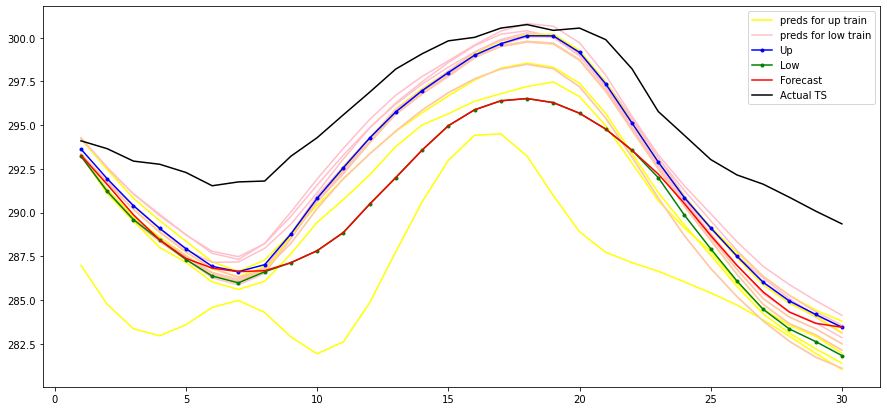

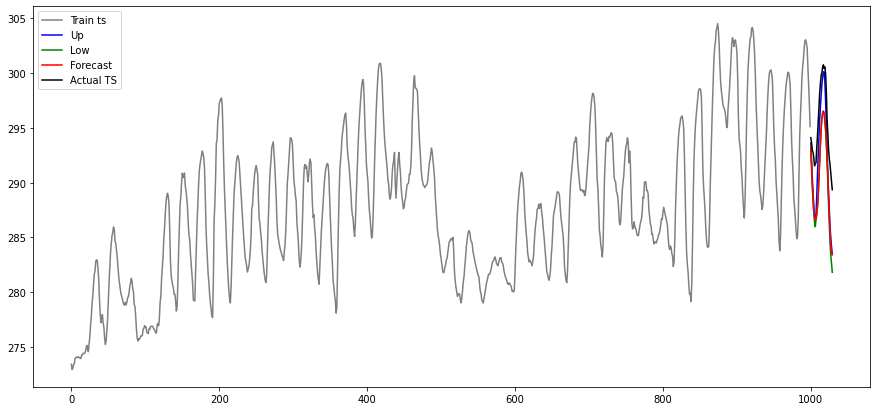

In [18]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)